In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
string.punctuation
!pip install emoji==1.7.0
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk import sent_tokenize 
from nltk import word_tokenize
from nltk.corpus import stopwords

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

# machine learning models
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 3.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=1e5b6b62893ca34af6efdb371345b0fdbe78a12195fffa8091d60db51026fd67
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Read dataset & Preprocess text
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kominfoPROA/copy assignment6/train.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kominfoPROA/copy assignment6/test.txt', names=['Text', 'Emotion'], sep=';')


In [4]:
df_train.head(7)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise


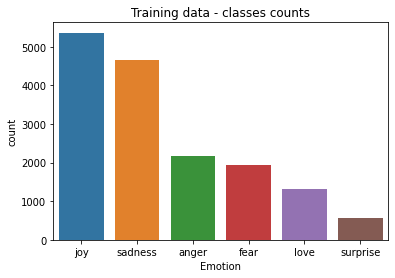

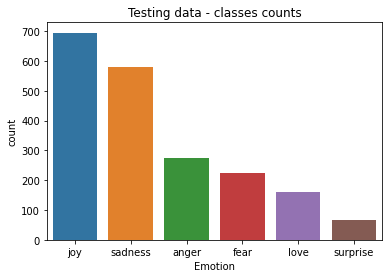

In [5]:
# Visualize classes counts
#colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

sns.countplot(data=df_train, x='Emotion', order = df_train['Emotion'].value_counts().index)
plt.title("Training data - classes counts")
plt.show()

sns.countplot(data=df_test, x='Emotion', order = df_test['Emotion'].value_counts().index)
plt.title("Testing data - classes counts")
plt.show()


**PreProcess Text (Basic Clean)**

In [6]:
def remove_punctuations(text):
    text = re.sub(r'[^A-Za-z|\s]','',text)
    return text

In [7]:
#remove emoji
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(r'', text)

In [8]:
def basicclean(df):
    for col in ['Text']: #selected_text
        df[col] = df[col].astype(str).apply(lambda x: x.lower()) #lowercase text
        df[col] = df[col].astype(str).apply(lambda x:remove_punctuations(x)) #remove punctuation
        df[col] = df[col].apply(lambda x: str(x).replace(" s ", " ")) #remove ' s ' that was created after removing punctuations (like it's -> it s)
        df[col] = df[col].apply(lambda x: str(x).replace(" d ", " ")) #remove ' d ' that was created after removing punctuations (like I'd -> I d)
        df[col] = df[col].astype(str).apply(lambda x:remove_emoji(x)) #remove emoji     
        df[col] = df[col].astype(str).apply(lambda x: x.replace('\n', ' ')) #get rid white space
        df[col] = df[col].str.replace('https?://www\.\S+\.com', '', case=False) #remove links
    return df

In [9]:
df_train2 = basicclean(df_train)
df_test2 = basicclean(df_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


**Lemmatization using NLTK WordNet**

In [10]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  temp = []
  for word in text.split():
    word = lemmatizer.lemmatize(word)
    temp.append(word)

  return ' '.join(temp)

In [11]:
df_train2['lemmatized'] = df_train2['Text'].apply(lambda x: lemmatize(x))
#After lemmatization, some pronouns are changed to '-PRON' and we're going to remove it
df_train2['lemmatized'] = df_train2['Text'].apply(lambda x: x.replace('-PRON-', ' '))

df_test2['lemmatized'] = df_test2['Text'].apply(lambda x: lemmatize(x))
df_test2['lemmatized'] = df_test2['Text'].apply(lambda x: x.replace('-PRON-', ' '))

**Tokenization**

In [12]:
df_train2['tokenized_clean'] = df_train2['lemmatized'].apply(word_tokenize)

df_test2['tokenized_clean'] = df_test2['lemmatized'].apply(word_tokenize)

**Removing Stop Words**

In [13]:
from collections import Counter
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

df_train2['tokenized_clean'] = df_train2['tokenized_clean'].apply(lambda text_list: [x for x in text_list if x not in stopwords_dict])

df_test2['tokenized_clean'] = df_test2['tokenized_clean'].apply(lambda text_list: [x for x in text_list if x not in stopwords_dict])

In [14]:
finale_tr = list()
for list_of_words in df_train2.tokenized_clean:
  finale_tr.append(' '.join(list_of_words))
df_train2['final_text'] = finale_tr

finale_te = list()
for list_of_words in df_test2.tokenized_clean:
  finale_te.append(' '.join(list_of_words))
df_test2['final_text'] = finale_te

In [15]:
df_train2.head(5)

,Text,Emotion,lemmatized,tokenized_clean,final_text
0,i didnt feel humiliated,sadness,i didnt feel humiliated,"[didnt, feel, humiliated]",didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,i can go from feeling so hopeless to so damned...,"[go, feeling, hopeless, damned, hopeful, aroun...",go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing a minute to post i feel greedy wrong,"[im, grabbing, minute, post, feel, greedy, wrong]",im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,i am ever feeling nostalgic about the fireplac...,"[ever, feeling, nostalgic, fireplace, know, st...",ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,i am feeling grouchy,"[feeling, grouchy]",feeling grouchy


In [16]:
X_train = df_train2['final_text']
y_train = df_train2['Emotion']

X_test = df_test2['final_text']
y_test = df_test2['Emotion']

In [17]:
pipe_lr = Pipeline(steps=[('Tfidf',TfidfVectorizer()),('lr',LogisticRegression(multi_class = 'multinomial', max_iter = 2000))])
pipe_dt = Pipeline(steps=[('Tfidf',TfidfVectorizer()),('lr',DecisionTreeClassifier())])
pipe_lgbm = Pipeline(steps=[('Tfidf',TfidfVectorizer()),('lr',LGBMClassifier())])

In [18]:
print('check',pipe_lr.fit(X_train,y_train))
print('check',pipe_dt.fit(X_train,y_train))
print('check',pipe_lgbm.fit(X_train,y_train))

check Pipeline(steps=[('Tfidf', TfidfVectorizer()),
                ('lr',
                 LogisticRegression(max_iter=2000, multi_class='multinomial'))])
check Pipeline(steps=[('Tfidf', TfidfVectorizer()), ('lr', DecisionTreeClassifier())])
check Pipeline(steps=[('Tfidf', TfidfVectorizer()), ('lr', LGBMClassifier())])


In [19]:
print('Score',pipe_lr.score(X_test,y_test))
print('Score',pipe_dt.score(X_test,y_test))
print('Score',pipe_lgbm.score(X_test,y_test))

Score 0.8645
Score 0.8615
Score 0.883


In [20]:
#check
ex1 = "i hope i get the job cause im in desperate need of money and i feel greedy"

In [21]:
pipe_lgbm.predict([ex1])

array(['anger'], dtype=object)

In [22]:
pipe_lgbm.predict_proba([ex1])

array([[9.57221623e-01, 2.81002386e-03, 2.31518591e-02, 1.56148208e-03,
        1.51004239e-02, 1.54588461e-04]])

In [23]:
pipe_lgbm.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [25]:
pipe_lr.predict([ex1])

array(['anger'], dtype=object)

In [26]:
pipe_lr.predict_proba([ex1])

array([[0.63570807, 0.04507237, 0.11557123, 0.0464335 , 0.14229555,
        0.01491928]])

In [27]:
import joblib
pipeline_file1 = open("nlp_classicML(lgbm).pkl","wb")
joblib.dump(pipe_lgbm,pipeline_file1)
pipeline_file1.close()


pipeline_file2 = open("nlp_classicML(lr).pkl","wb")
joblib.dump(pipe_lr,pipeline_file2)
pipeline_file2.close()
